# First Step to Lattice-based Cryptanalysis in SageMath

> by Kurt Pan @ [ZKPunk](https://zkpunk.pro)

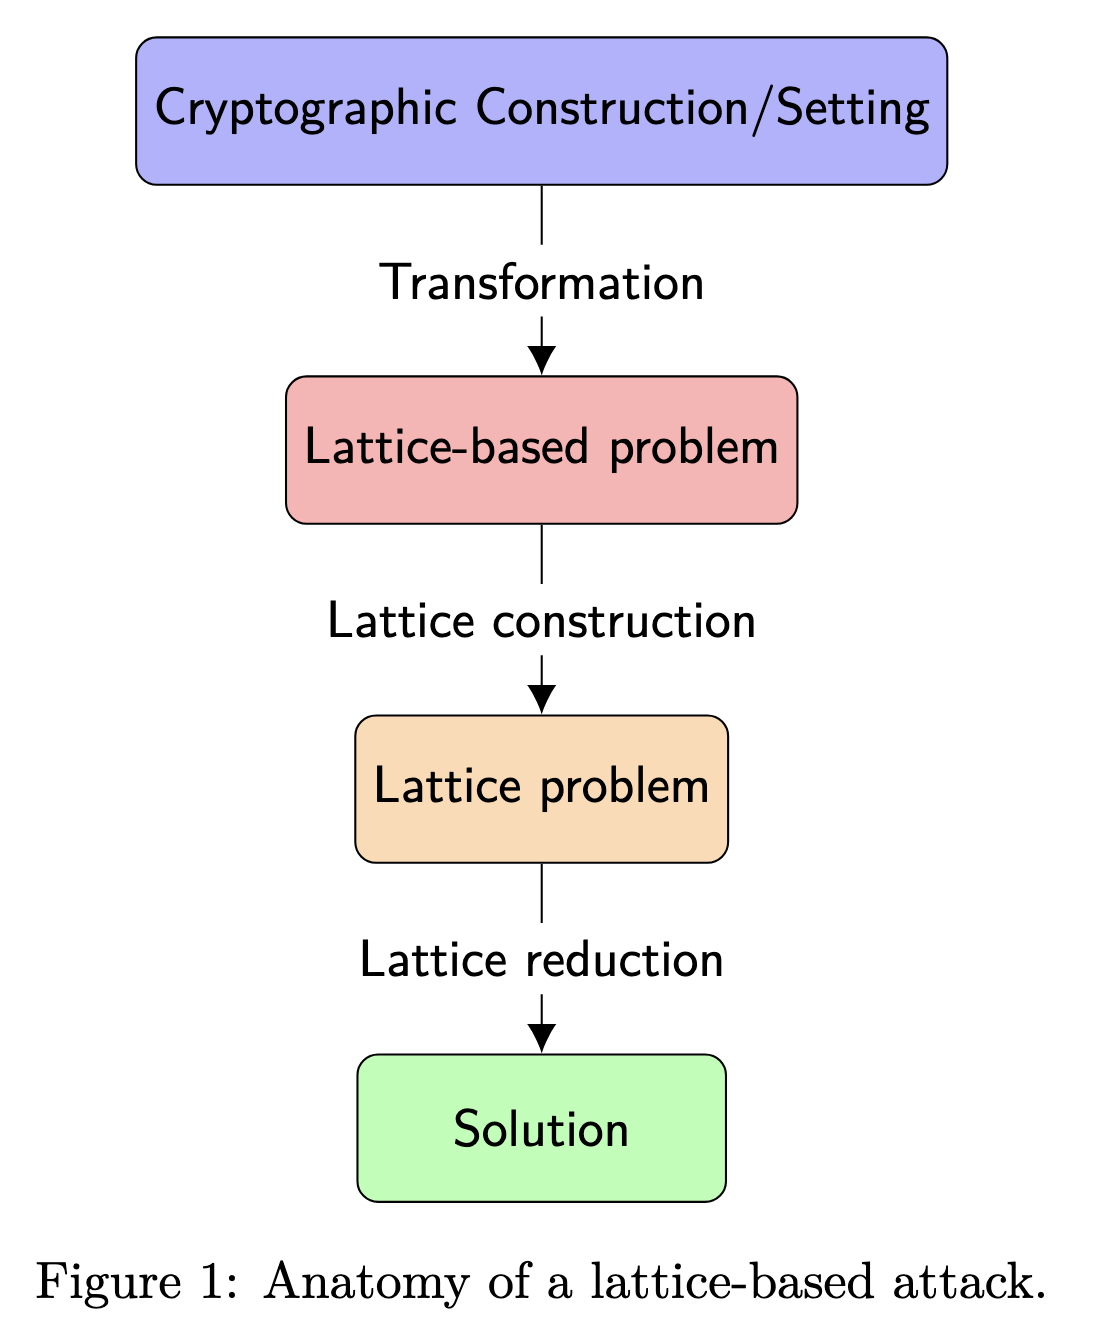

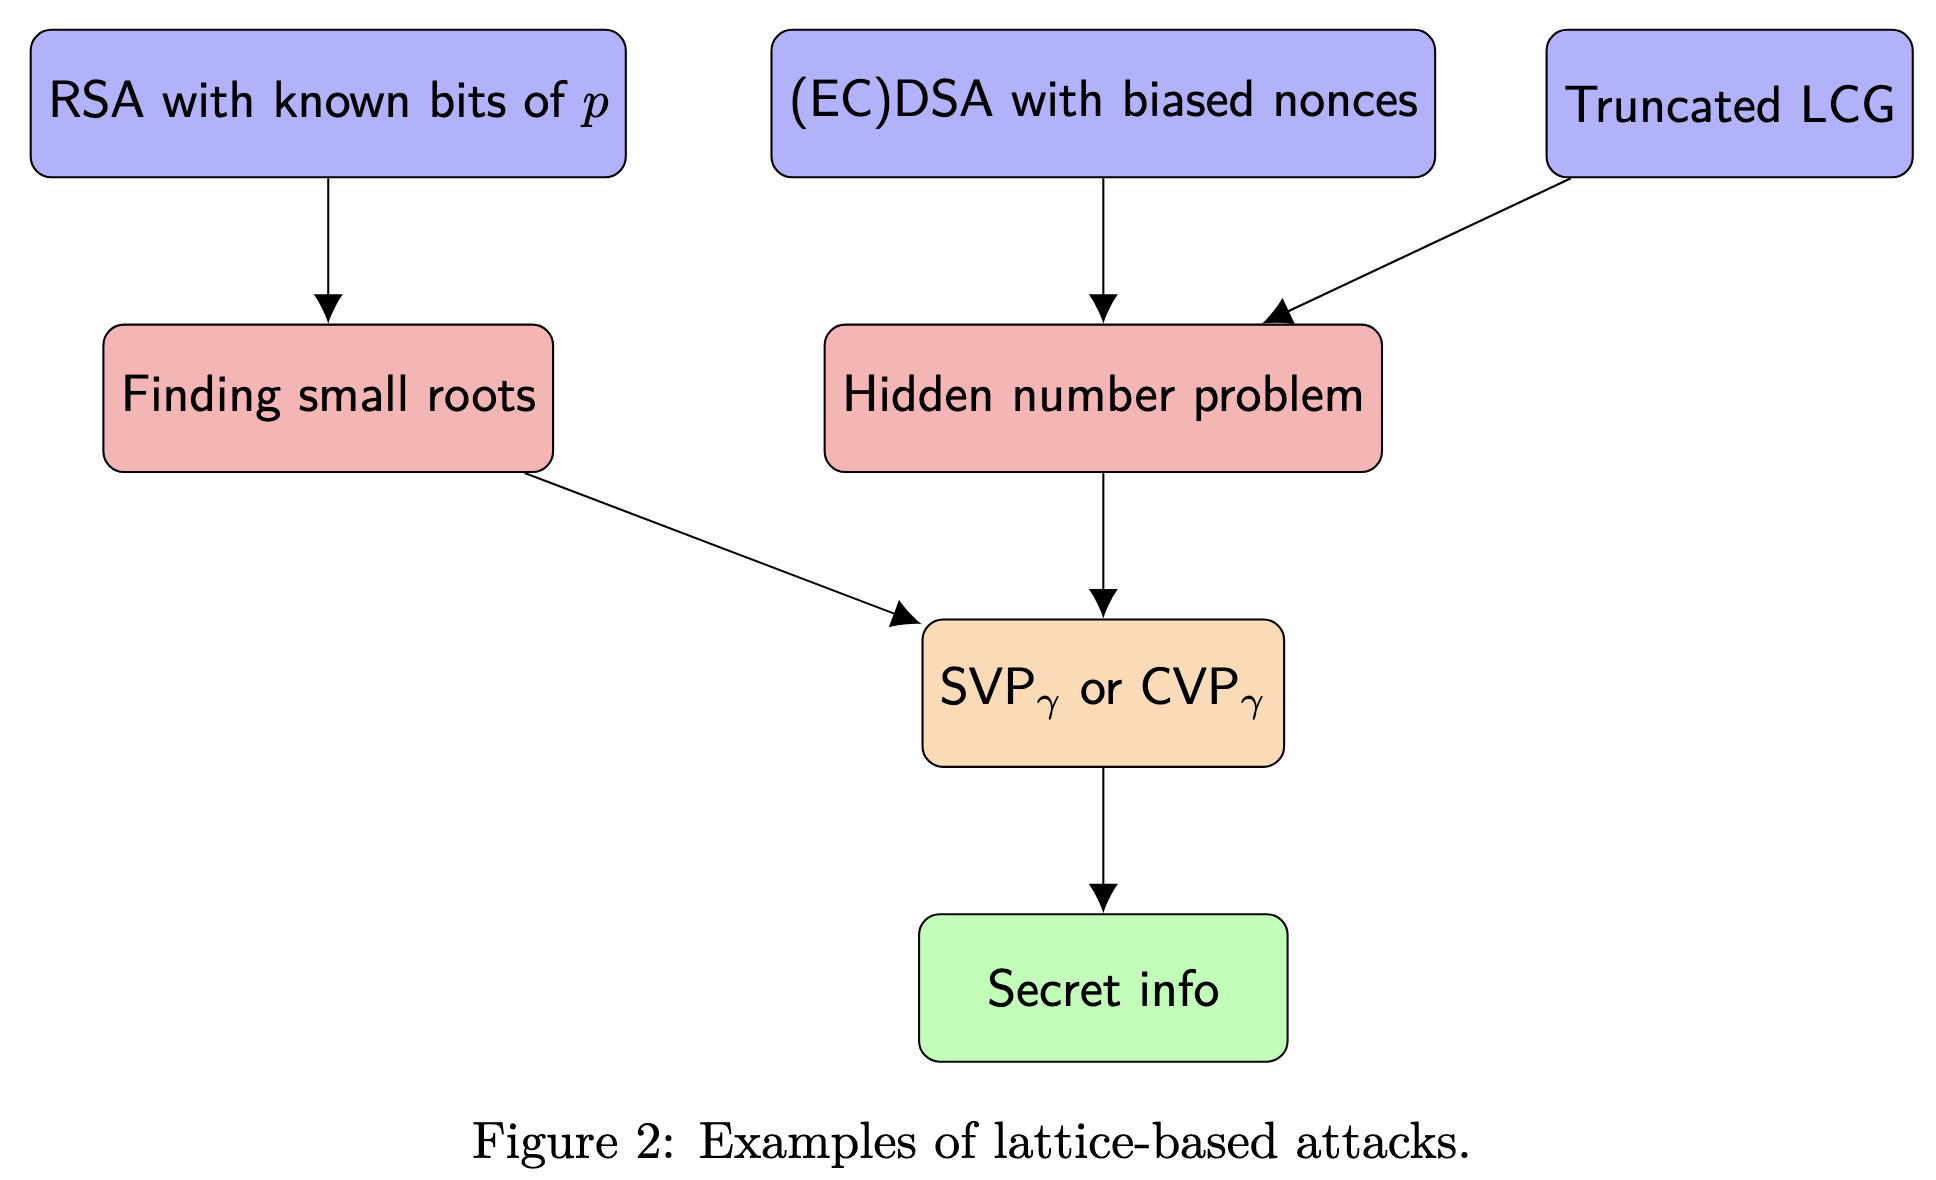

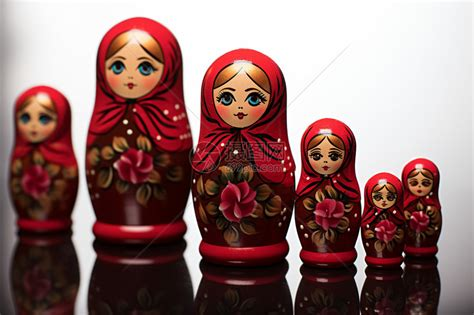


Refs:
- [A Gentle Tutorial for Lattice-Based Cryptanalysis](https://eprint.iacr.org/2023/032)
- [Linear algebra and lattice reduction in Sage](https://defeo.lu/sage-lattices-EJCIM/)
- [Cryptanalysis on Lattice-Based Cryptography](https://hackmd.io/@Giapppp/BJ4wfpZST)
- [Using Lattices for Cryptanalysis](https://simons.berkeley.edu/sites/default/files/docs/14975/cryptanalysis.pdf)
- [Solving Hidden Number Problem with One Bit Oracle and Advice](https://www.iacr.org/archive/crypto2009/56770333/56770333.pdf)
- [Sage for Lattice-based Cryptography](https://www.maths.ox.ac.uk/system/files/attachments/sage-introduction.pdf)
- https://www.latticechallenge.org/
- https://lattice-estimator.readthedocs.io/en/latest/
- [The GGH Cryptosystem](https://kel.bz/post/lattices/)
- [Building Lattice Reduction (LLL) Intuition](https://kel.bz/post/lll/)
- [LLL algorithm](https://www.youtube.com/watch?v=vREqxm0j784)
- COMPLEXITY OF LATTICE PROBLEMS: A Cryptographic Perspective Ch2
- Mathematics of Public Key Cryptography. Version 2.0 by Steven D Galbraith

In [1]:
B  = matrix([[-2,2],[-2,1]])
B

[-2  2]
[-2  1]

In [2]:
B.LLL()

[ 0 -1]
[-2  0]

In [3]:
B.BKZ()

[ 0 -1]
[-2  0]

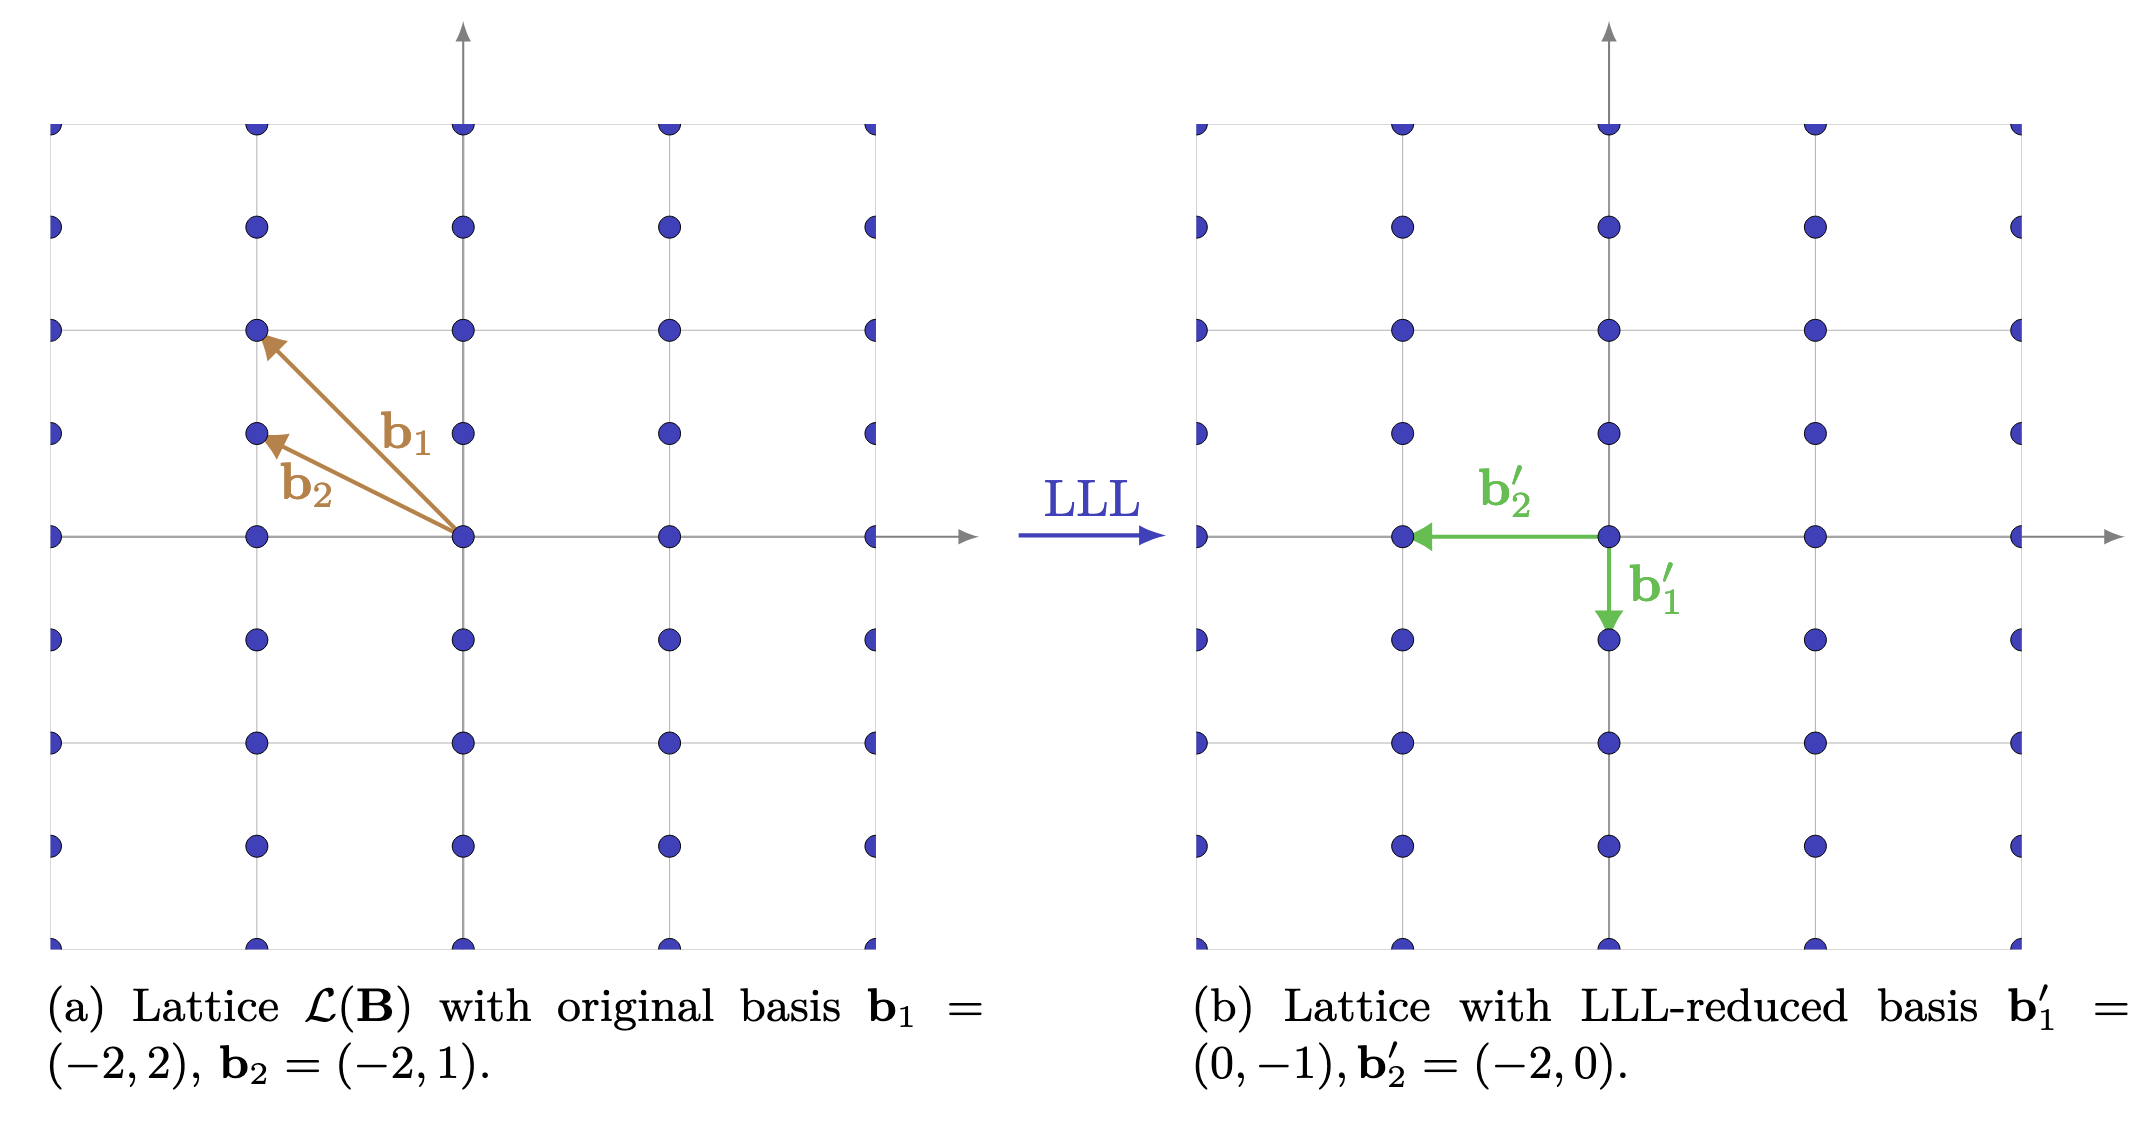

## Lattice-based Attacks
Lattice-based attacks are attacks <font color="yellow">using lattices against cryptographic constructions</font>. 


### ecdsa_nonce_hash_xor_privkey

```pytion
ecdsa_nonce_hash_xor_privkey(Z, R, S, n)
```

Recovers the (EC)DSA private signing key given at least two messages and their signatures where the nonces $k_i$ were generated as $k_i = z_i \oplus d$ (i.e. message hash XOR private key). 

**Arguments:**

&nbsp;&nbsp;&bull;&nbsp; `Z` - A list of the message hashes $z_i$.

&nbsp;&nbsp;&bull;&nbsp; `R` - A list of the $r_i$.

&nbsp;&nbsp;&bull;&nbsp; `S` - A list of the $s_i$.

&nbsp;&nbsp;&bull;&nbsp; `n` - The modulus $n$.

**Returns:**

The (EC)DSA private signing key $d$.

In [4]:
from lbc_toolkit import ecdsa_nonce_hash_xor_privkey

In [5]:
# secp256k1
p = 0xfffffffffffffffffffffffffffffffffffffffffffffffffffffffefffffc2f 
a, b = 0, 7 # y^2 = x^3 + 7
n = 0xfffffffffffffffffffffffffffffffebaaedce6af48a03bbfd25e8cd0364141
E = EllipticCurve(GF(p), [a, b])
G = E(0x79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798, 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8)

In [6]:
ell = 3
print(f'ECDSA k = z ⊕ d attack with ell = {ell}')
Z, R, S = [], [], []
d_ = randrange(1, n)
for i in range(ell):
    z = randrange(1, n)
    k = d_ ^^ z
    X = k * G
    r = int(X.xy()[0]) % n
    s = pow(k, -1, n) * (z + r * d_) % n
    Z.append(ZZ(z)); R.append(ZZ(r)); S.append(ZZ(s))
print(f'Z: {Z} \n R:{R} \n S:{S}')

ECDSA k = z ⊕ d attack with ell = 3
Z: [40158939334239771085186345813988284321475298553032946142808776308517126232355, 10263731867467130476891361419719020654219073006678761156220278659432100316638, 93832211787401370754669711158080455241827217904673492520835225409857942336754] 
 R:[3016406666953579940058863383656688008553852596293226998665092945776886933323, 69279327245905693223259736635726360553149755269876029627758104513351085078843, 68490791582828283666223591773824985479199669435248683540673615515308451261706] 
 S:[27085056783186418747293927485821318652836944183585344792065201605765516079507, 17061301929111395448998506435826410086768774467003804878022299949502444357524, 101211873492206722632384394957040415383702912523454995838975522107404845638258]


In [7]:
d = ecdsa_nonce_hash_xor_privkey(Z, R, S, n)
print('  Actual solution:', d_)
print('  Found  solution:', d)

[subset_sum] Density: 0.3333
[subset_sum] Lattice dimensions: (260, 260)
[subset_sum] Lattice reduction took 6.938s
  Actual solution: 94893380599505757455235797215681909011099659696076178403734478274118865679913
  Found  solution: 94893380599505757455235797215681909011099659696076178403734478274118865679913


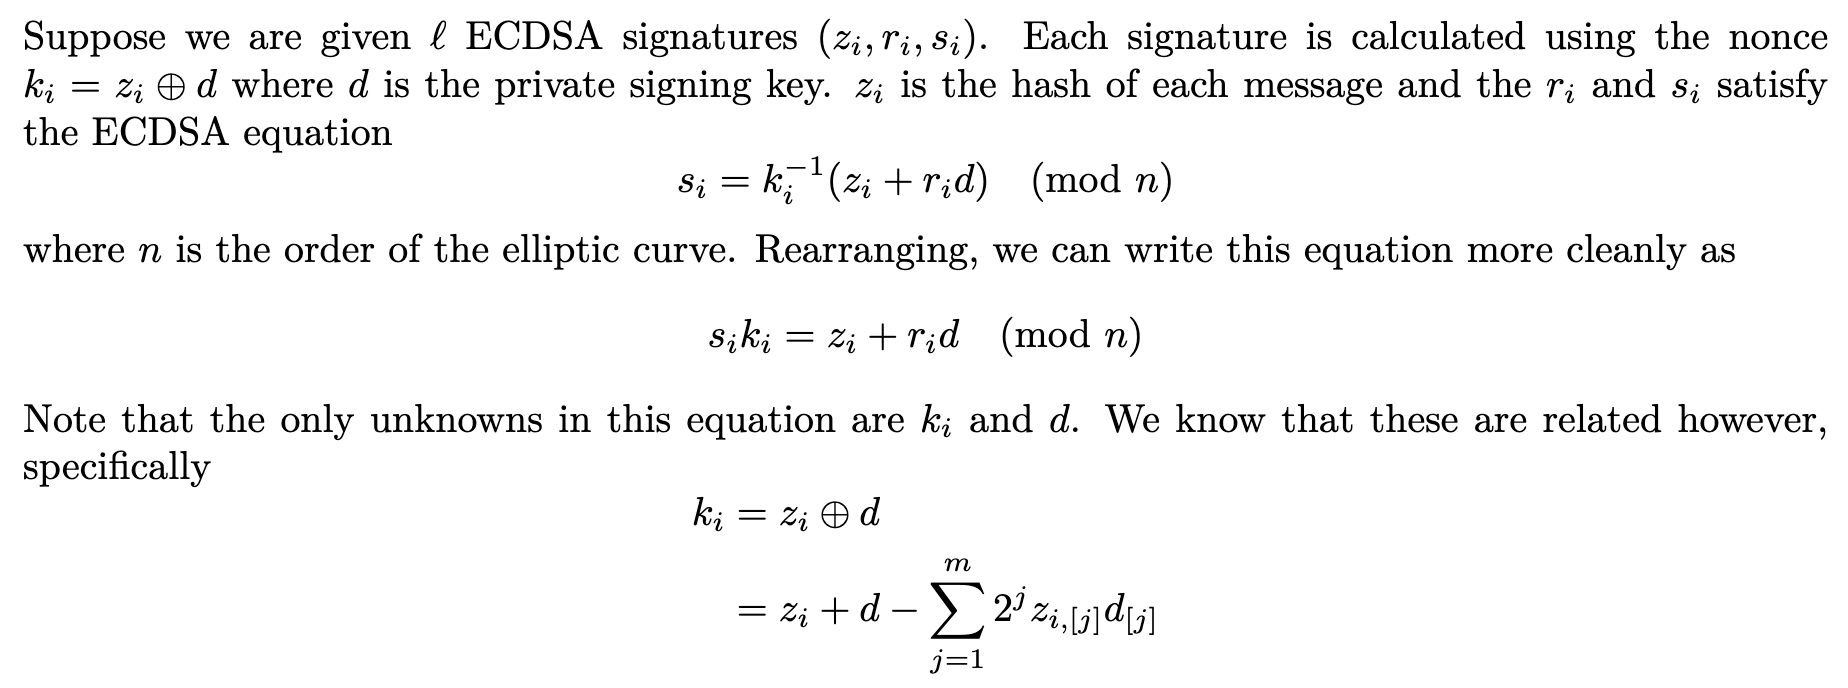
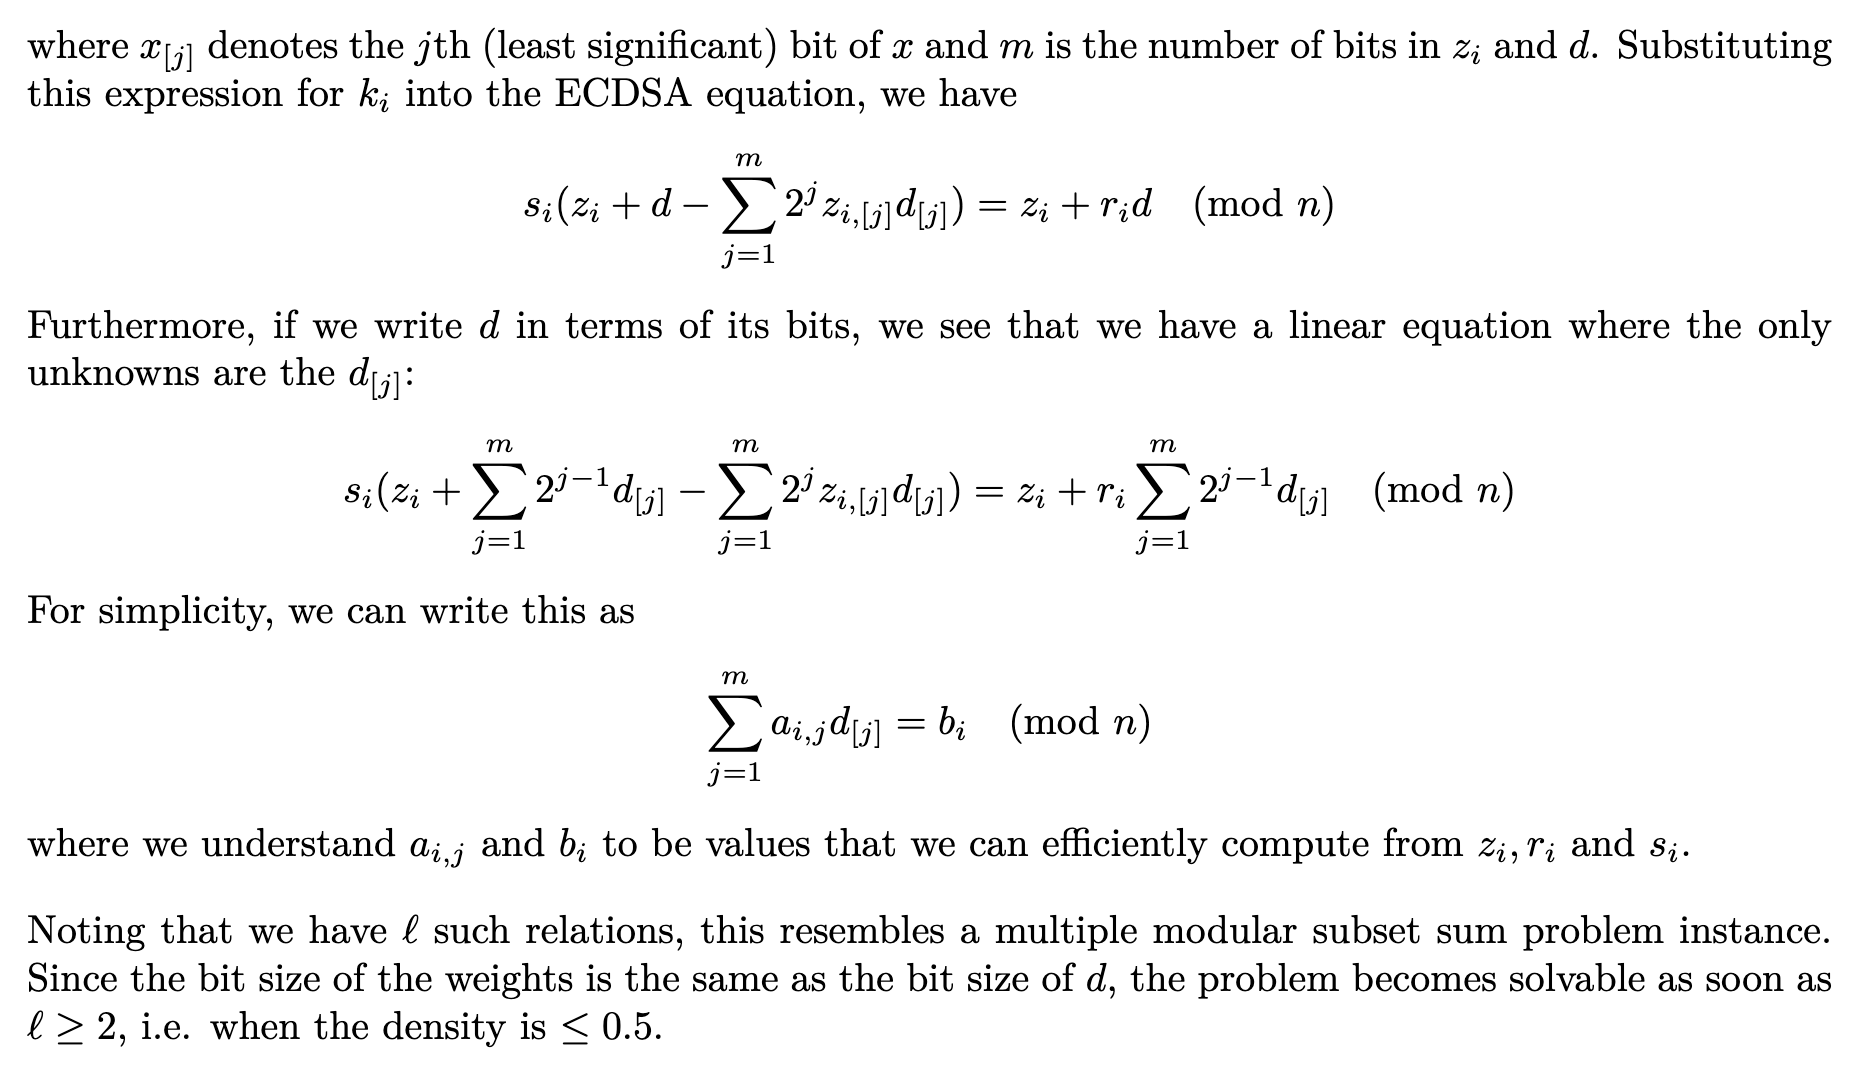

In [8]:
def demo_ecdsa_nonce_hash_xor_privkey(Z, R, S, n):
    jth_bit = lambda x, j: (x >> j) & 1

    ell = len(Z)
    m = n.nbits()
    P = PolynomialRing(GF(n), [f'd{j}' for j in range(m)])
    d_bits = list(P.gens())
    d = sum(2^j * d_bits[j] for j in range(m))

    weights = []
    targets = []
    for i in range(ell):
        k_i = Z[i] + d - 2 * sum(2^j * jth_bit(Z[i], j) * d_bits[j] for j in range(m))
        eq = S[i] * k_i - (Z[i] + R[i] * d)
        coeffs = [c for c, _ in eq]
        weights.append([ZZ(x) for x in coeffs[:-1]])
        targets.append(-ZZ(coeffs[-1]))

    sol = subset_sum(weights, targets, n, verbose=True)
    d = int(''.join(map(str, sol))[::-1], 2)
    return d

### ecdsa_biased_nonce

```py
ecdsa_biased_nonce_zero_msb(Z, R, S, n, l)
ecdsa_biased_nonce_zero_lsb(Z, R, S, n, l)
ecdsa_biased_nonce_known_msb(Z, R, S, T, n, l)
ecdsa_biased_nonce_shared_msb(Z, R, S, n, l)
```

Implementation of a few different variations of attacks against (EC)DSA with biased nonces as described in [HS01]. The signatures satisfy the DSA equation

$$
s_i = k_i^{-1}(z_i + r_i d) \pmod n
$$

Given many messages $z_i$ and their signatures $(r_i, s_i)$ calculated with the biased nonces $k_i$, the private signing key $d$ may be recovered.

**Arguments:**

&nbsp;&nbsp;&bull;&nbsp; `Z` - A list of the message hashes $z_i$.

&nbsp;&nbsp;&bull;&nbsp; `R` - A list of the $r_i$.

&nbsp;&nbsp;&bull;&nbsp; `S` - A list of the $s_i$.

&nbsp;&nbsp;&bull;&nbsp; `n` - The modulus $n$.

&nbsp;&nbsp;&bull;&nbsp; `l` - The number of bits of bias.

In the `ecdsa_biased_nonce_known_msb` function, the argument `T` is the list of known MSBs of each $k_i$.

**Returns:**

The (EC)DSA private signing key $d$.

## Lattice-based Problems

### Knapsack Problem
The knapsack problem is a well-known NP-complete computational problem that has been used as a trapdoor in some public key cryptosystems [MH78, CR88, Yas07]. The most common version of the knapsack problem in cryptography and cryptanalysis is the <font color="yellow"> subset sum problem </font> which involves *finding a subset of a given set of numbers that sum to a given target*. 


```python
subset_sum(weights, targets, modulus=None, N=None, lattice_reduction=None, verbose=False)
```

Finds the solution of the subset sum problem with the given `weights` and `targets`. Supports multiple knapsacks as well as the modular case with the `modulus` argument. 

**Arguments:**

&nbsp;&nbsp;&bull;&nbsp; `weights` - A list of integer weights $a_1, \ldots, a_n$, or a list of lists $a_{1, 1}, \ldots, a_{k, n}$ for the multiple subset sum problem with $k$ different subset sums.

&nbsp;&nbsp;&bull;&nbsp; `targets` - The integer target $s$, or a list of targets $s_1, \ldots, s_j$ for the multiple subset sum problem case.

&nbsp;&nbsp;&bull;&nbsp; `modulus` - (optional) The modulus $M$.

&nbsp;&nbsp;&bull;&nbsp; `N` - (optional) The scaling factor $N$ as described in [PZ16]. (Default: $\lceil \sqrt{(n+1)/4} \rceil$)

**Returns:**

A solution to the given subset sum problem as a list representing the $e_i$ such that

$$
    \sum_{i=1}^n e_i a_{j, i} = s_j
$$

for all $1 \leq j \leq k$.

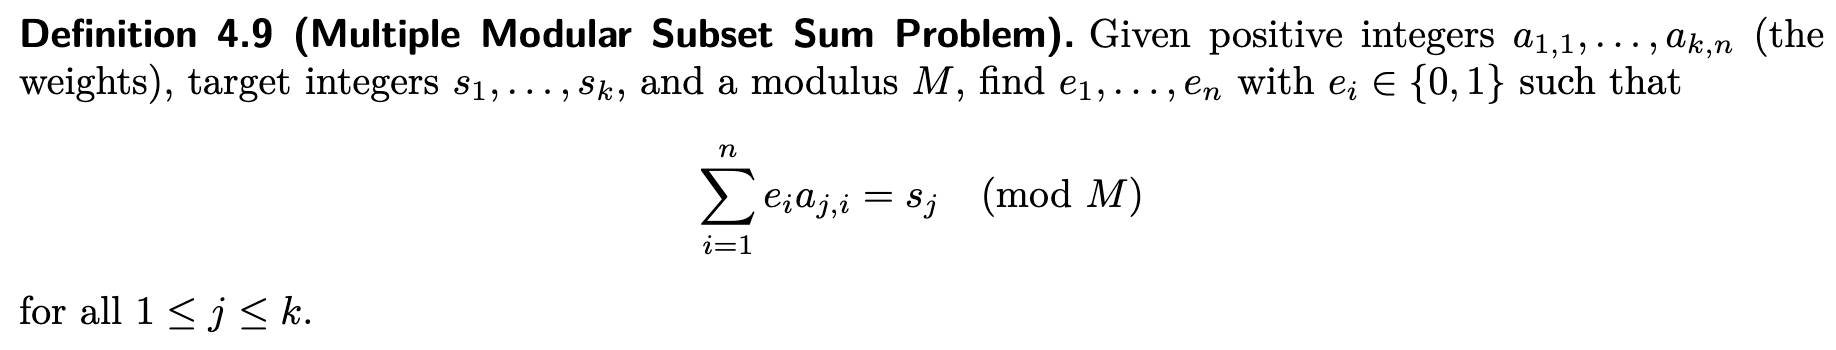
The density of the multiple modular subset sum problem is defined as $d=\frac{n}{k \cdot \log _2 M}$. 

In [9]:
from sage.modules.free_module_integer import IntegerLattice
from lbc_toolkit import subset_sum

def multiple_modular_subset_sum_example():
    print('Multiple Modular Subset Sum Example')
    U, M, k, n = 2^80, 2^80, 6, 100
    weights = [[randint(0, U) for _ in range(n)] for _ in range(k)]
    e = [randint(0, 1) for _ in range(n)]
    targets = [sum([e * a for e, a in zip(e, W)]) % M for W in weights]
    sol = subset_sum(weights, targets, modulus=M, verbose=True)
    assert sol
    assert all(targets[j] == sum([e * a for e, a in zip(sol, weights[j])]) % M for j in range(k))
    print('  Actual solution:', e)
    print('  Found  solution:', sol, end='\n\n')

multiple_modular_subset_sum_example()


Multiple Modular Subset Sum Example
[subset_sum] Density: 0.2083
[subset_sum] Lattice dimensions: (107, 107)
[subset_sum] Lattice reduction took 0.987s
  Actual solution: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]
  Found  solution: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]



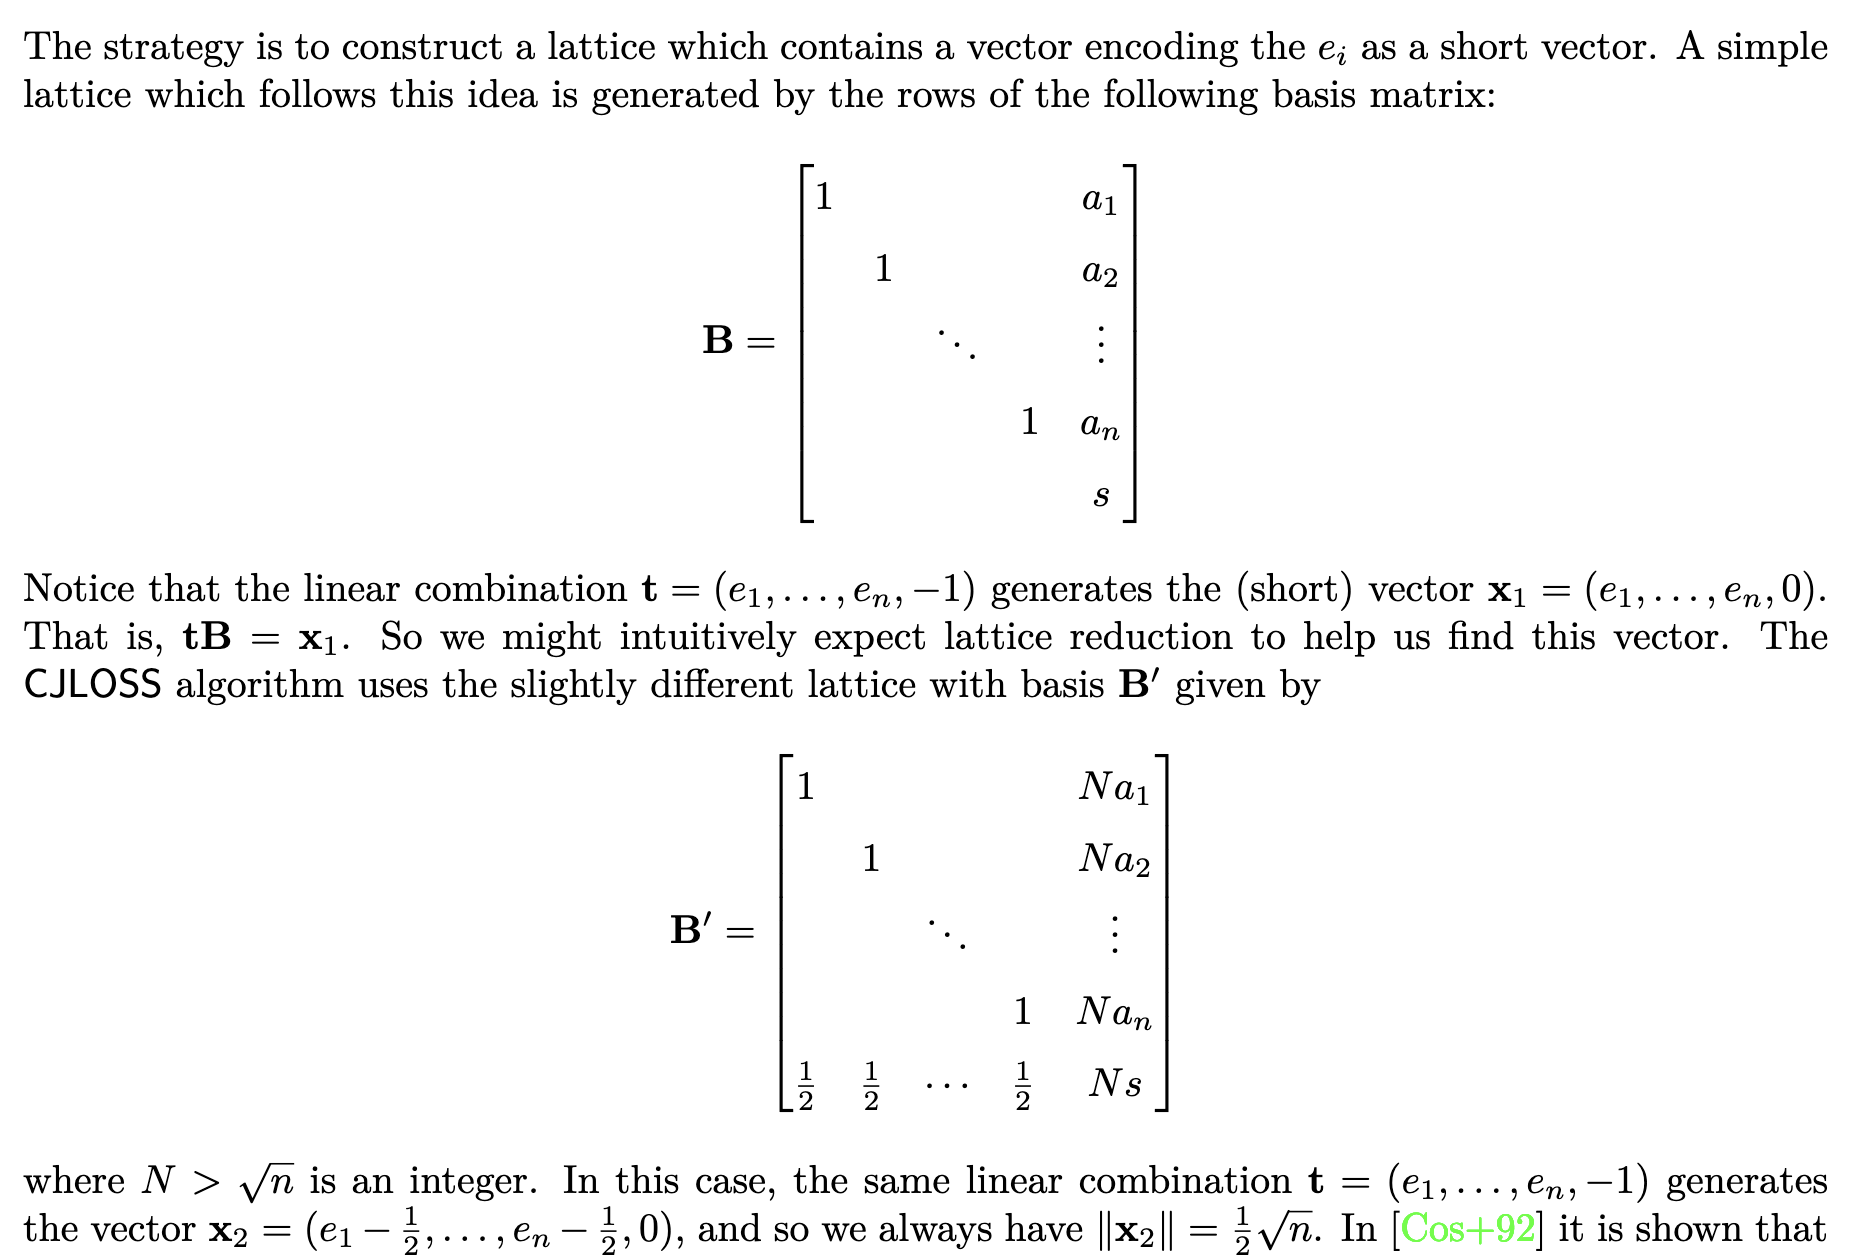
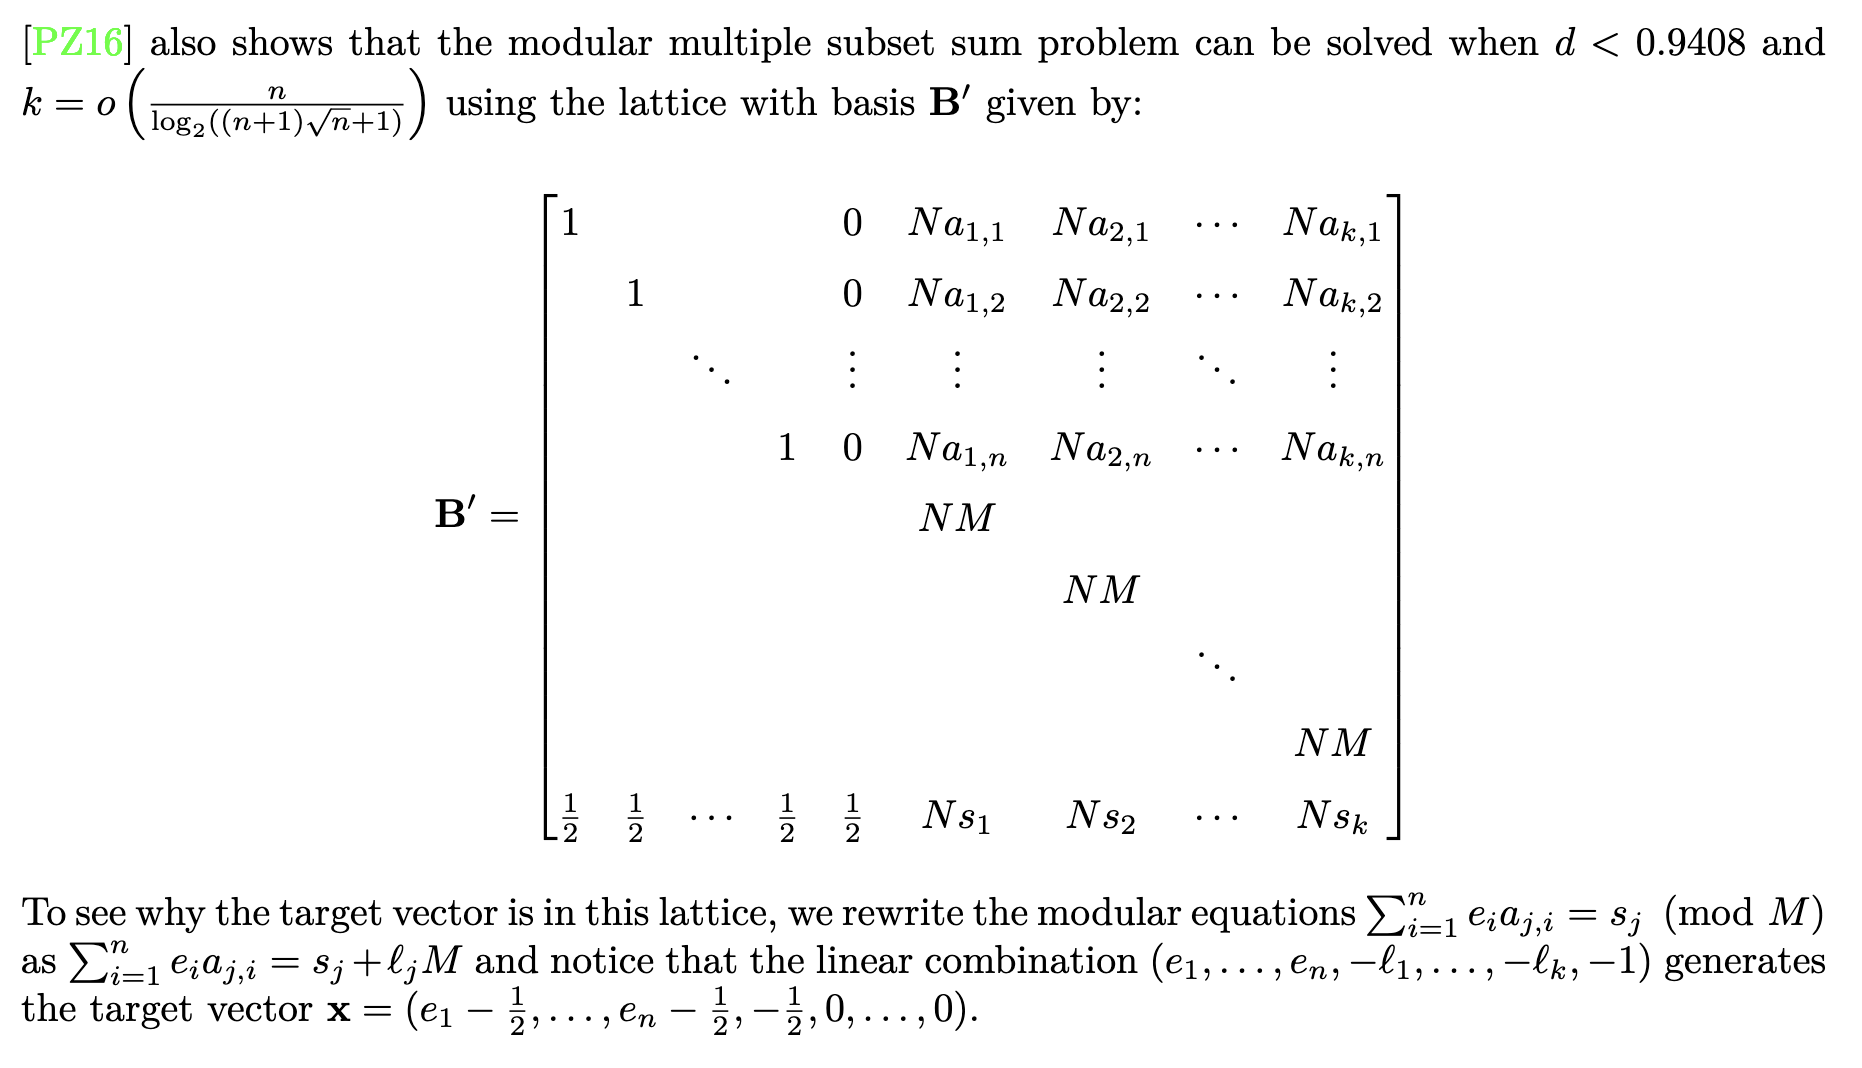
$N>\sqrt{\frac{n+1}{4}}$

**Example: n=2, k=1**

Modular equation: 3e₁ + 5e₂ ≡ 8 (mod 10), solution: e₁=1, e₂=1

Lattice basis B' (with N=2):

[1   0   0   6  ]  ← I_n and Na_{1,1}=2×3

[0   1   0   10 ]  ← I_n and Na_{1,2}=2×5

[0   0   0   20 ]  ← NM=2×10

[1/2 1/2 1/2 16 ]  ← 1/2 and Ns₁=2×8

Linear combination: (1, 1, 0, -1)
- 1×row1 = (1, 0, 0, 6)
- 1×row2 = (0, 1, 0, 10)
- 0×row3 = (0, 0, 0, 0)
- -1×row4 = (-1/2, -1/2, -1/2, -16)

Sum: (1/2, 1/2, -1/2, 6+10-16) = (1/2, 1/2, -1/2, 0)

Last coordinate is 0 because:
- 3×1 + 5×1 = 8 = 8 + 0×10
- So ℓ₁ = 0
- N(3+5) - 0×N×10 - N×8 = N×8 - N×8 = 0 ✓

In [10]:
def demo_subset_sum(weights, targets, modulus=None, N=None, lattice_reduction=None, verbose=False):
    verbose = (lambda *a: print('[subset_sum]', *a)) if verbose else lambda *_: None

    if type(weights[0]) is list:
        k = len(weights)
        n = len(weights[0])
    else:
        k = 1
        n = len(weights)
        weights = [weights]
        targets = [targets]

    if modulus is not None:
        density = n / (k * log(modulus, 2))
    else:
        density = n / (k * log(max(flatten(weights)), 2))
    verbose('Density:', round(density.n(), 4))

    N = N or ceil(sqrt((n+1)/4))
    B = 2 * Matrix.identity(n)
    B = B.augment(vector([0] * n))
    for j in range(k):
        B = B.augment(vector([N * a for a in weights[j]]))
    if modulus is not None:
        B = B.stack(Matrix.zero(k, n + 1).augment(N * modulus * Matrix.identity(k)))
    B = B.stack(vector([1] * (n + 1) + [N * s for s in targets]))

    verbose('Lattice dimensions:', B.dimensions())
    lattice_reduction_timer = cputime()
    if lattice_reduction:
        B = lattice_reduction(B)
    else:
        B = B.LLL()
    verbose(f'Lattice reduction took {cputime(lattice_reduction_timer):.3f}s')

    for row in B:
        if row[n] < 0:
            sol = [(x + 1)//2 for x in row[:n]]
        else:
            sol = [(1 - x)//2 for x in row[:n]]
        if any(x not in [0, 1] for x in sol):
            continue
        for j in range(k):
            t = sum(e * a for e, a in zip(sol, weights[j]))
            tj = targets[j]
            if modulus > 0:
                t %= modulus
                tj %= modulus
            if t != tj:
                break
        else:
            return sol
        
    return None


### Hidden Number Problem
Let $p$ be a prime and let $\alpha \in[1, p-1]$ be a secret integer. Recover $\alpha$ given $m$ pairs of integers $\left\{\left(t_i, a_i\right)\right\}_{i=1}^m$ such that

$$
\beta_i-t_i \alpha+a_i=0 \quad(\bmod p)
$$

where the $\beta_i$ are unknown and satisfy $\left|\beta_i\right|<B$ for some $B<p$.
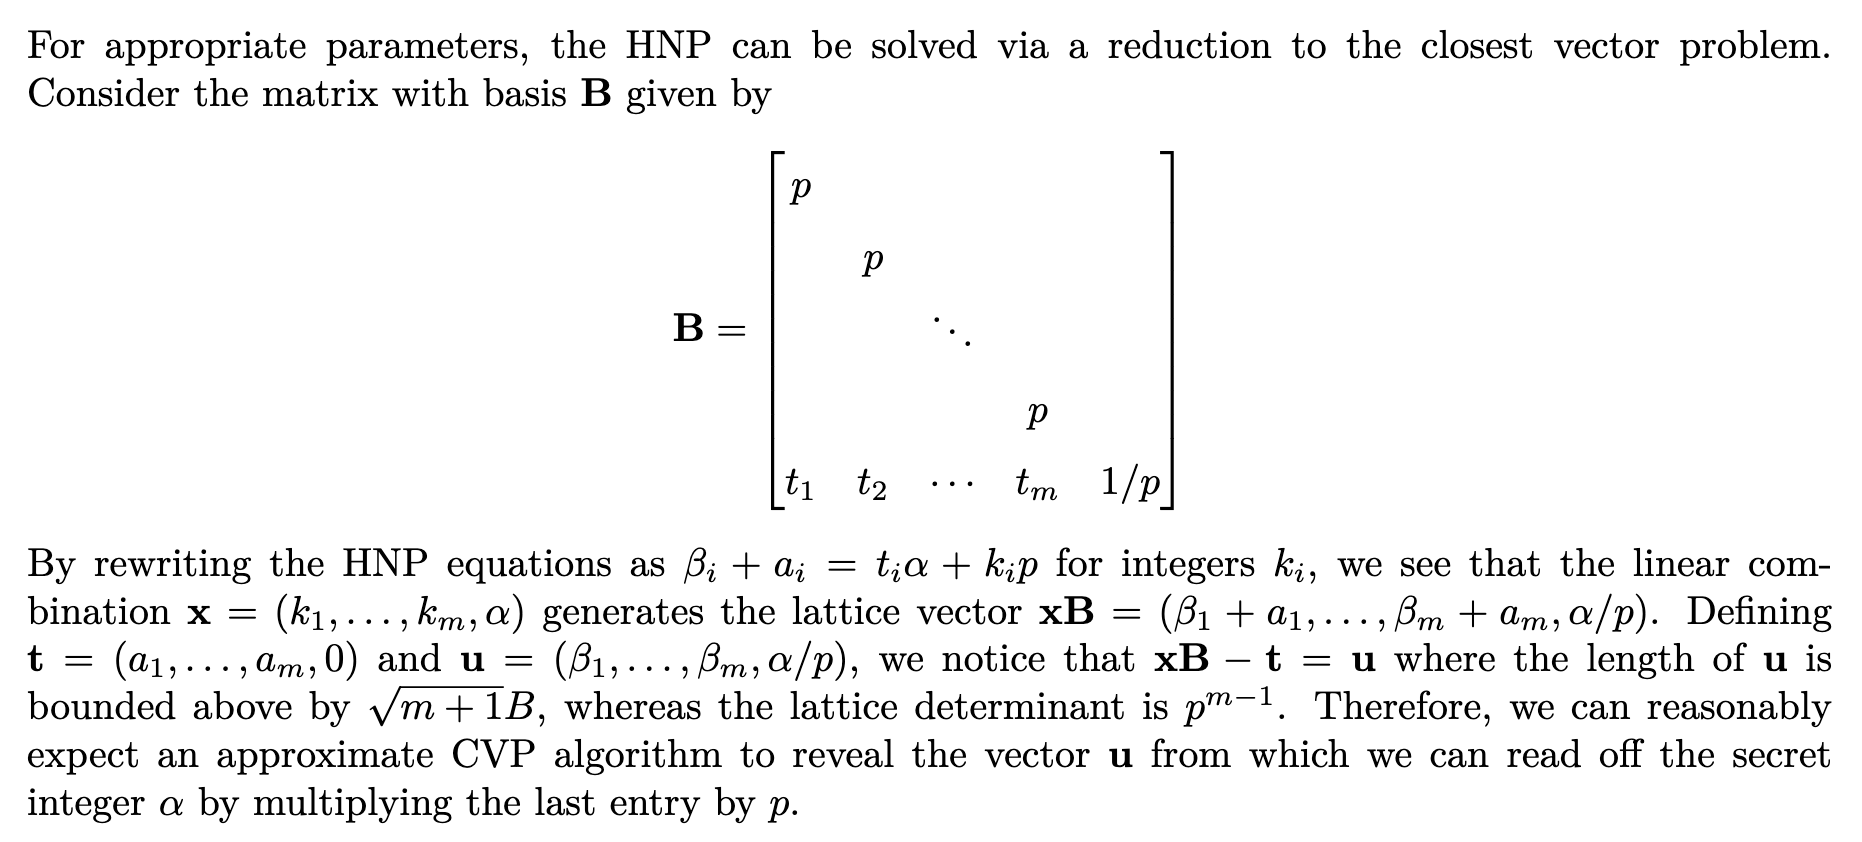

In [11]:
from lbc_toolkit import hnp, ehnp
print('HNP Example')
p, m, B = random_prime(2^10), 2, 2^3
#_alpha = randrange(1, p)
_alpha = 666
T = [randrange(1, p) for _ in range(m)]
_Beta = [randrange(0, B) for _ in range(m)]
A = [(t * _alpha - beta) % p for t, beta in zip(T, _Beta)]
sol = hnp(p, T, A, B, verbose=True)
print('  Actual solution:', _alpha)
print('  Found  solution:', sol, end='\n\n')

HNP Example
[hnp] Lattice dimensions: (4, 4)
[hnp] Lattice reduction took 0.003s
  Actual solution: 666
  Found  solution: 666



In [12]:
def demo_hnp(p, T, A, B, lattice_reduction=None, verbose=False):
    r"""
    Returns the solution of the given hidden number problem instance. i.e. finds
    `\alpha \in [1, p - 1]` satisfying

    .. MATH::

        \beta_i - t_i \alpha + a_i \equiv 0 \pmod p

    where the `t_i` and `a_i` are given by ``T`` and ``A``, and the `\beta_i`
    are bounded above by ``B``.
    """

    verbose = (lambda *a: print('[hnp]', *a)) if verbose else lambda *_: None

    if len(T) != len(A):
        raise ValueError(f'Expected number of t_i to equal number of a_i, but got {len(T)} and {len(A)}.')

    m = len(T)
    M = p * Matrix.identity(QQ, m)
    M = M.stack(vector(T))
    M = M.stack(vector(A))
    M = M.augment(vector([0] * m + [B / p] + [0]))
    M = M.augment(vector([0] * (m + 1) + [B]))
    M = M.dense_matrix()

    verbose('Lattice dimensions:', M.dimensions())
    lattice_reduction_timer = cputime()
    if lattice_reduction:
        M = lattice_reduction(M)
    else:
        M = M.LLL()
    verbose(f'Lattice reduction took {cputime(lattice_reduction_timer):.3f}s')

    for row in M:
        if row[-1] == -B:
            alpha = (row[-2] * p / B) % p
            if all((beta - t * alpha + a) % p == 0 for beta, t, a in zip(row[:m], T, A)):
                return alpha
        if row[-1] == B:
            alpha = (-row[-2] * p / B) % p
            if all((beta - t * alpha + a) % p == 0 for beta, t, a in zip(-row[:m], T, A)):
                return alpha

    return None

## Lattice ALgorithms
### The LLL Algorithm
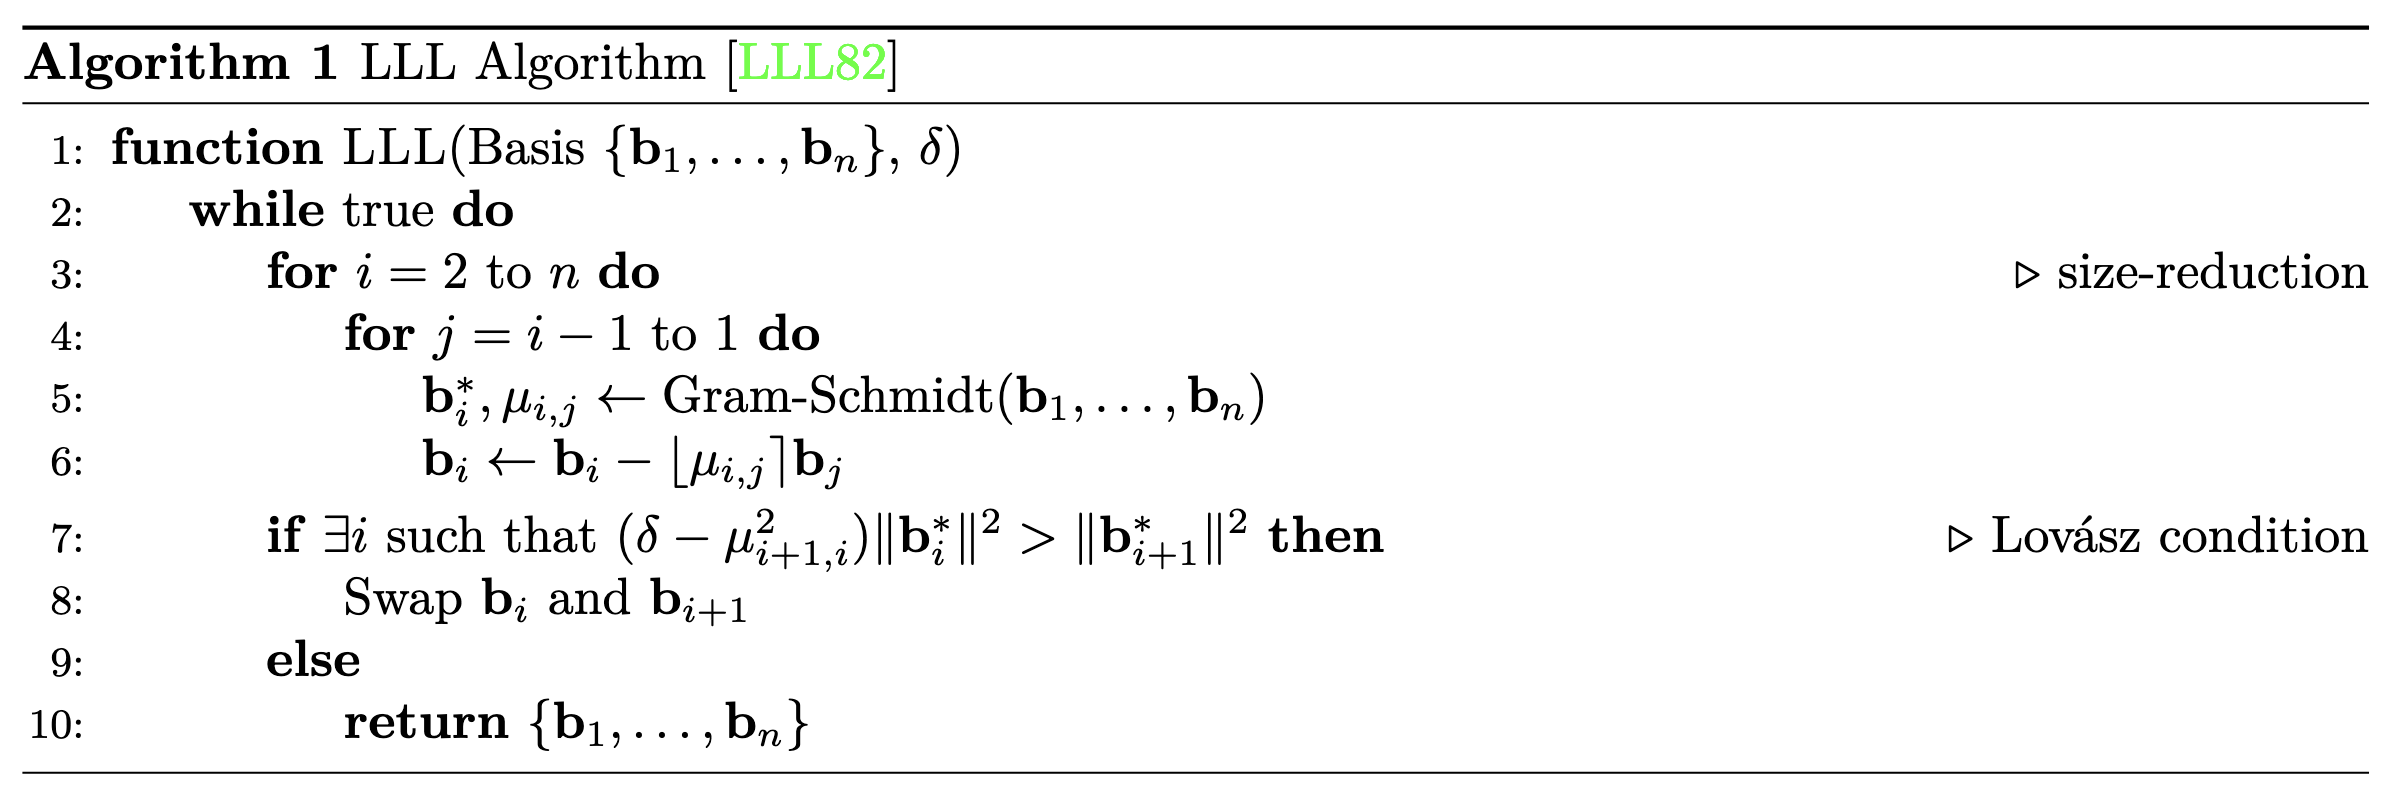

Let $\mathbf{B}=\left\{\mathbf{b}_1, \mathbf{b}_2\right\}$ where $\mathbf{b}_1=(-2,2), \mathbf{b}_2=(-2,1)$. We will run the LLL algorithm on this lattice basis, using $\delta=0.75$

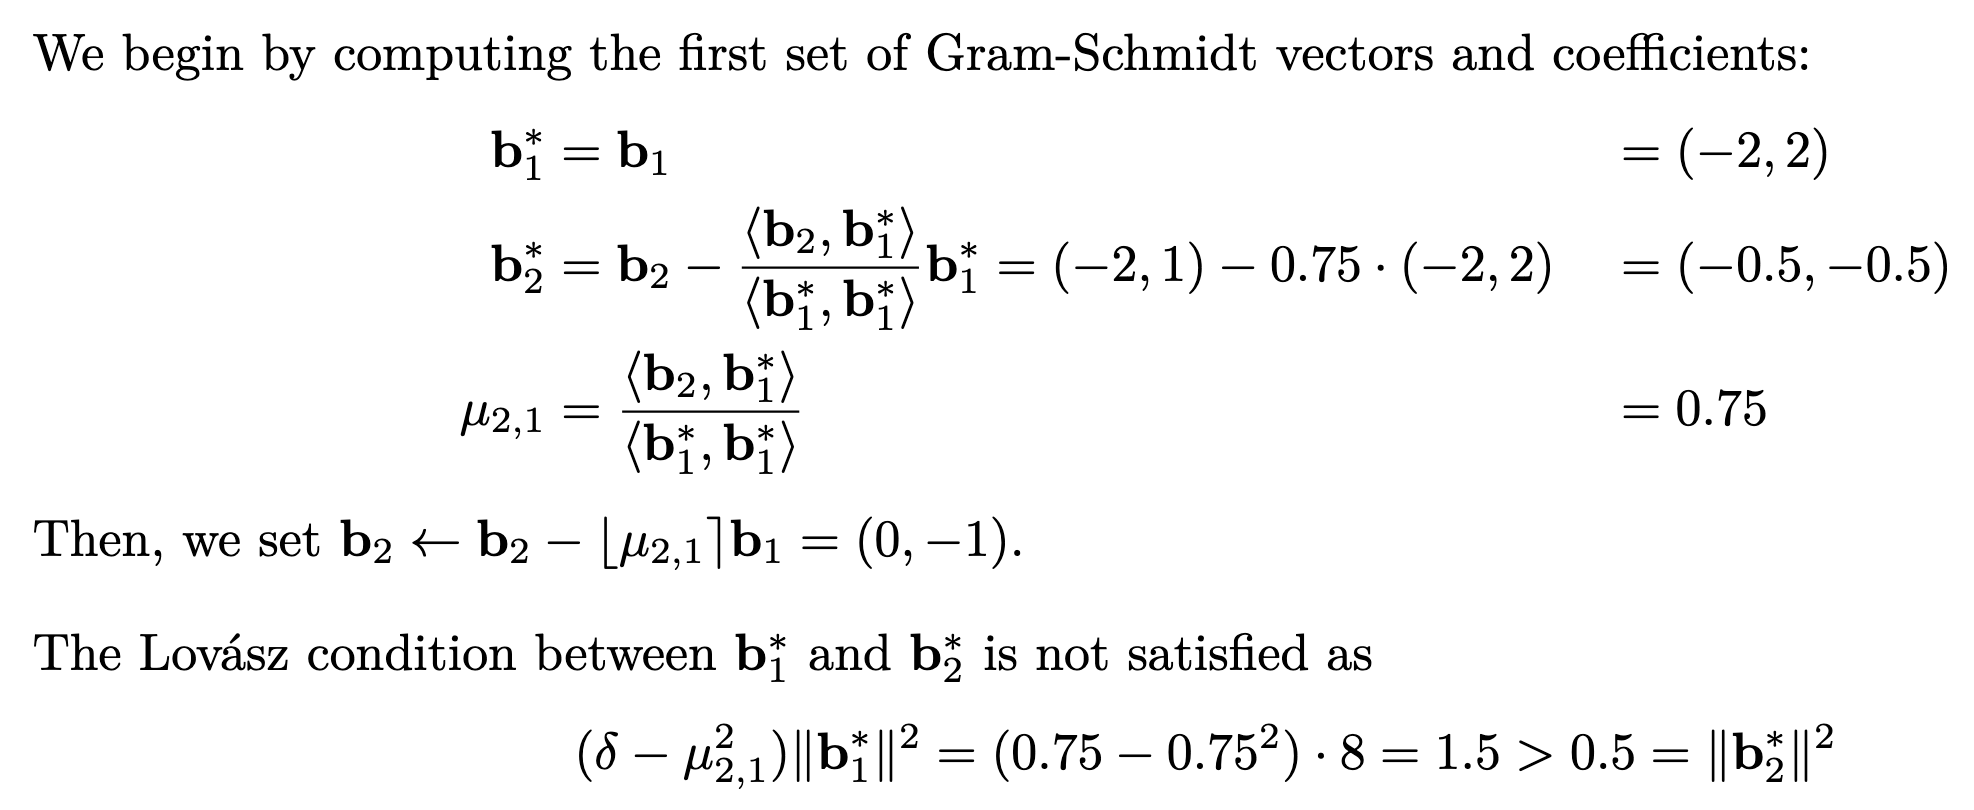
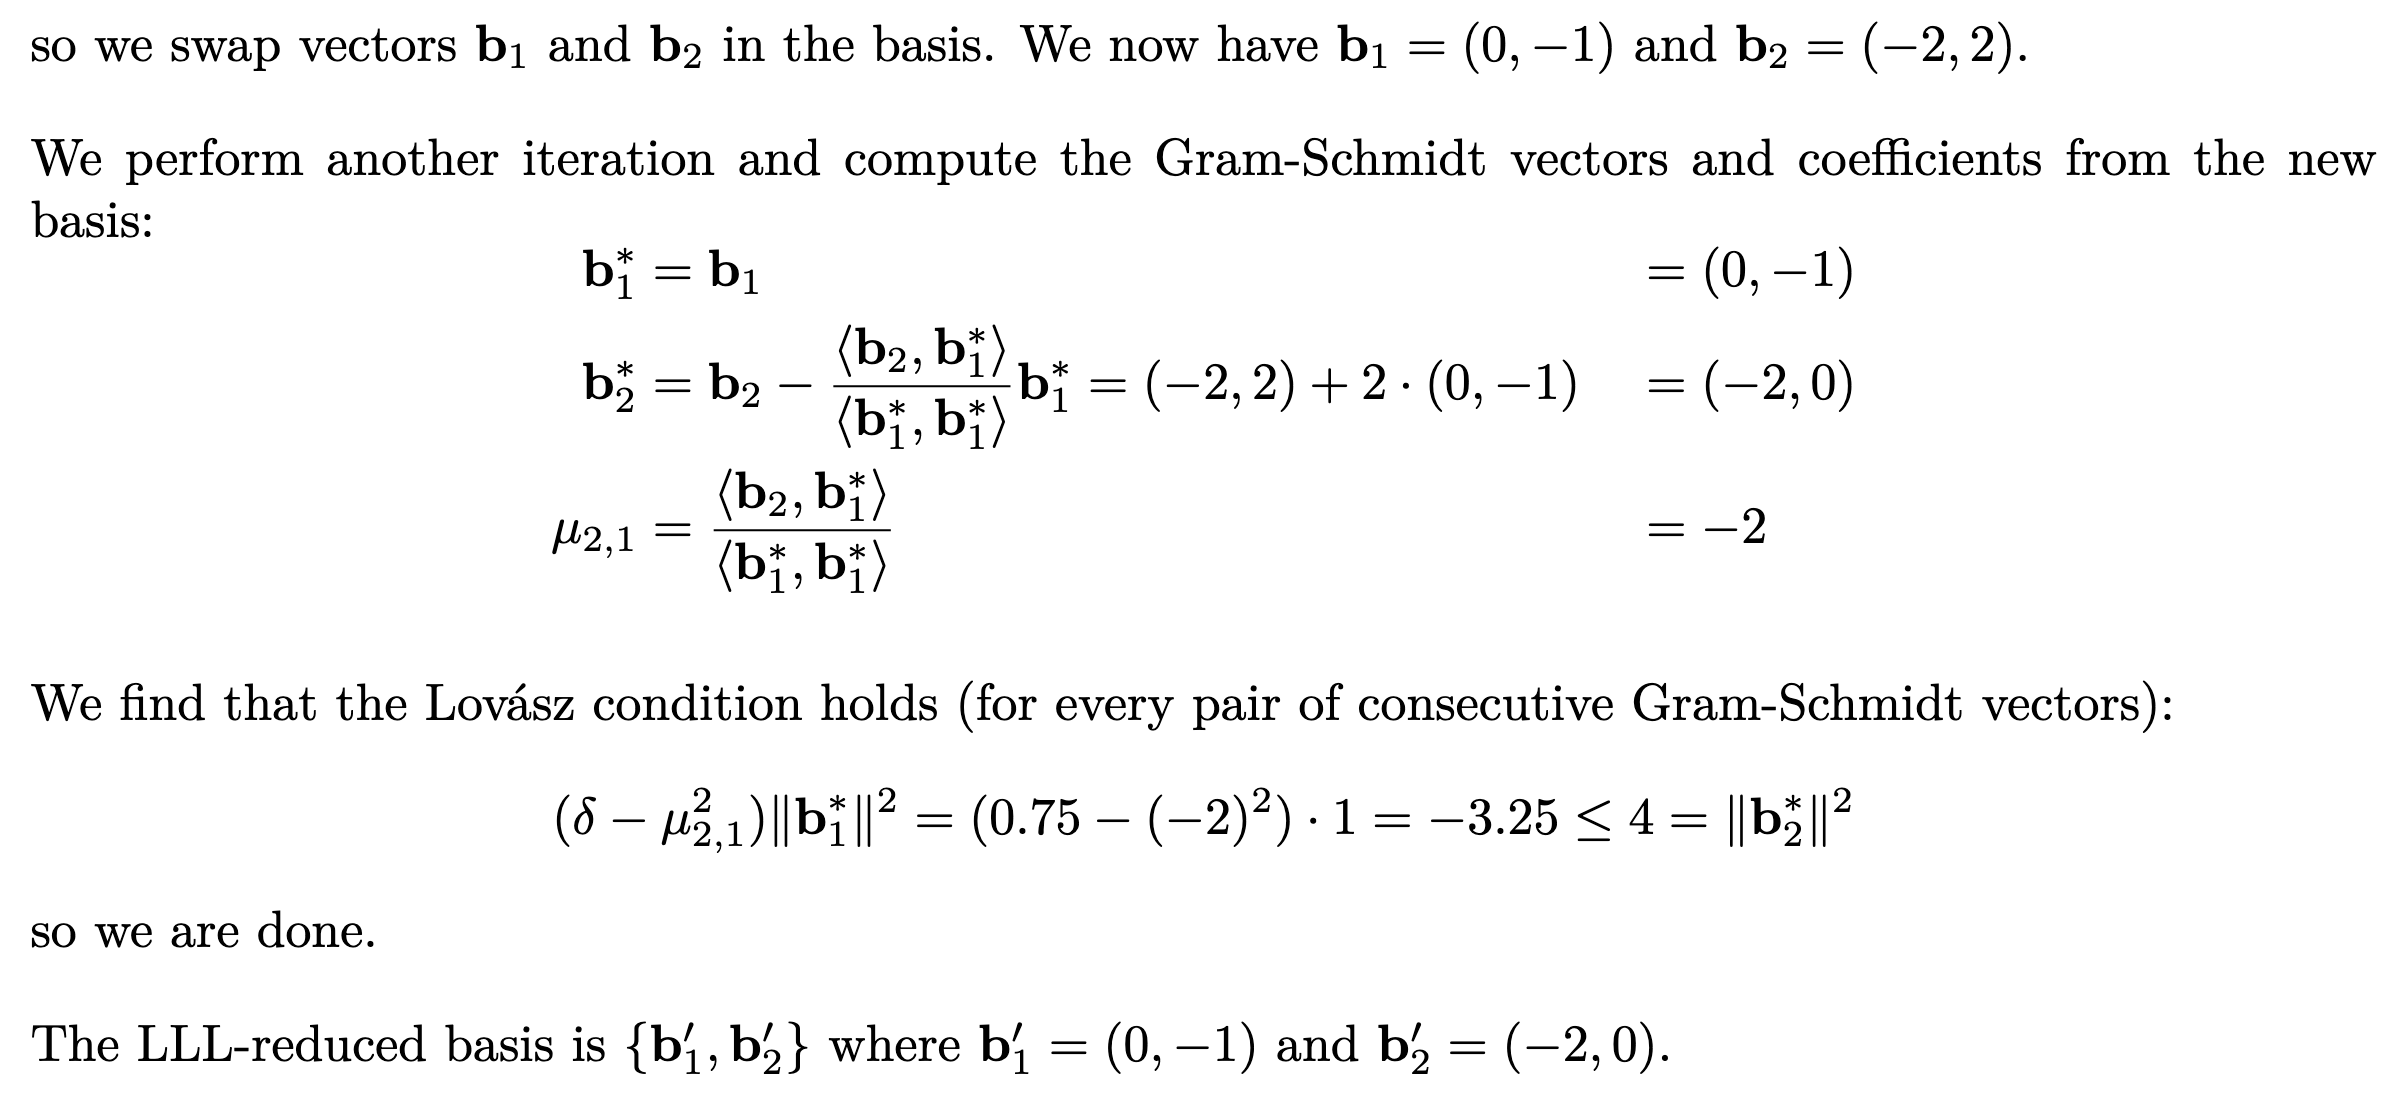

> both algorithms use a `reduce-and-then-swap` technique to achieve their goals.
> - We can roughly say that *LLL is an extension of Euclid's algorithm* that applies to a set of $n$-vectors instead of integers.
> - LLL extends Gauss’ algorithm for reduction to work with $n$ vectors.
> - Round version of GSO

In [13]:
def project(v, u):
    """Project vector v onto vector u"""
    if u.dot_product(u) == 0:
        return vector([0] * len(v))  # Handle zero vector case
    return (v.dot_product(u) / u.dot_product(u)) * u

# Usage
v = vector([2, 2])
u = vector([3, 1])
proj = project(v, u)
proj

(12/5, 4/5)

In [16]:
B  = matrix([[-2,2],[-2,1]])
G, M = B.gram_schmidt()
B,G

(
[-2  2]  [  -2    2]
[-2  1], [-1/2 -1/2]
)

In [17]:
B.LLL()

[ 0 -1]
[-2  0]

In [18]:
def plot_2d_lattice(v1, v2, xmin=-10, xmax=10, ymin=-10, ymax=10, show_basis_vectors=True):
    """
    sage plot of a lattice with v1 and v2 as basis vectors.
    """

    pts = []
    # plot all integer multiples of the basis so long as the x and y coordinates
    # are within (x|y)(min|max).
    for i in range(xmin, xmax):
        for j in range(ymin, ymax):
            pt = i*v1 + j*v2
            x,y = pt[0], pt[1]
            if x < xmin or x > xmax or y < ymin or y > ymax:
                continue
            pts.append(pt)
    the_plot = plot(points(pts))
    if show_basis_vectors:
        the_plot += plot(v1) + plot(v2)
    return the_plot

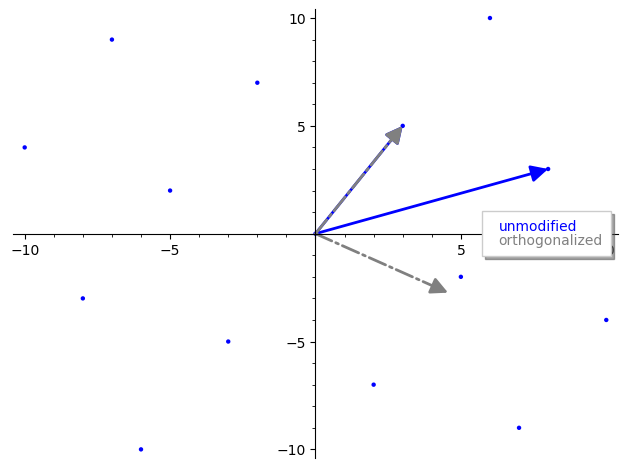

In [19]:
v1 = vector(ZZ, [3,5])
v2 = vector(ZZ, [8,3])
V  = Matrix(ZZ, [v1,v2])
Vr,_ = V.gram_schmidt()
pplot = plot_2d_lattice(V[0], V[1])
pplot += plot(Vr[0], color='grey', linestyle='-.', legend_label='unmodified', legend_color='blue')
pplot += plot(Vr[1], color='grey', linestyle='-.', legend_label='orthogonalized', legend_color='grey')
pplot

In [20]:
Vr

[     3      5]
[155/34 -93/34]

### Solving CVP
#### Babai’s Nearest Plane Algorithm
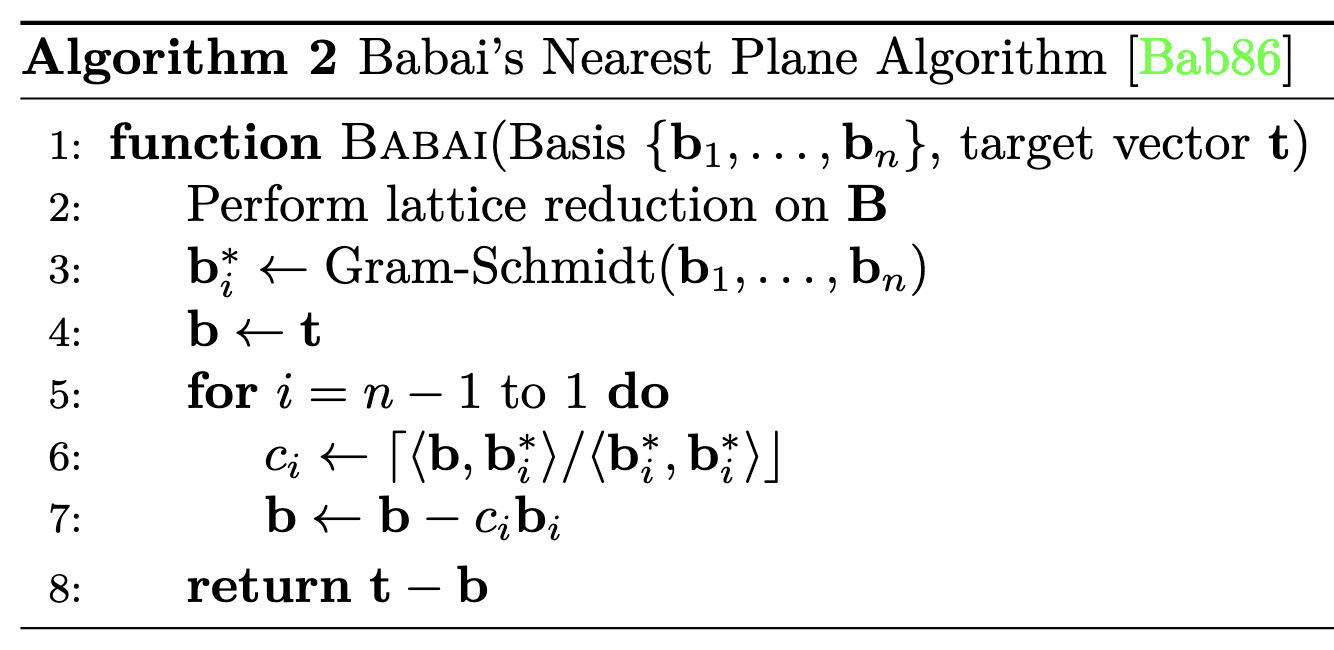
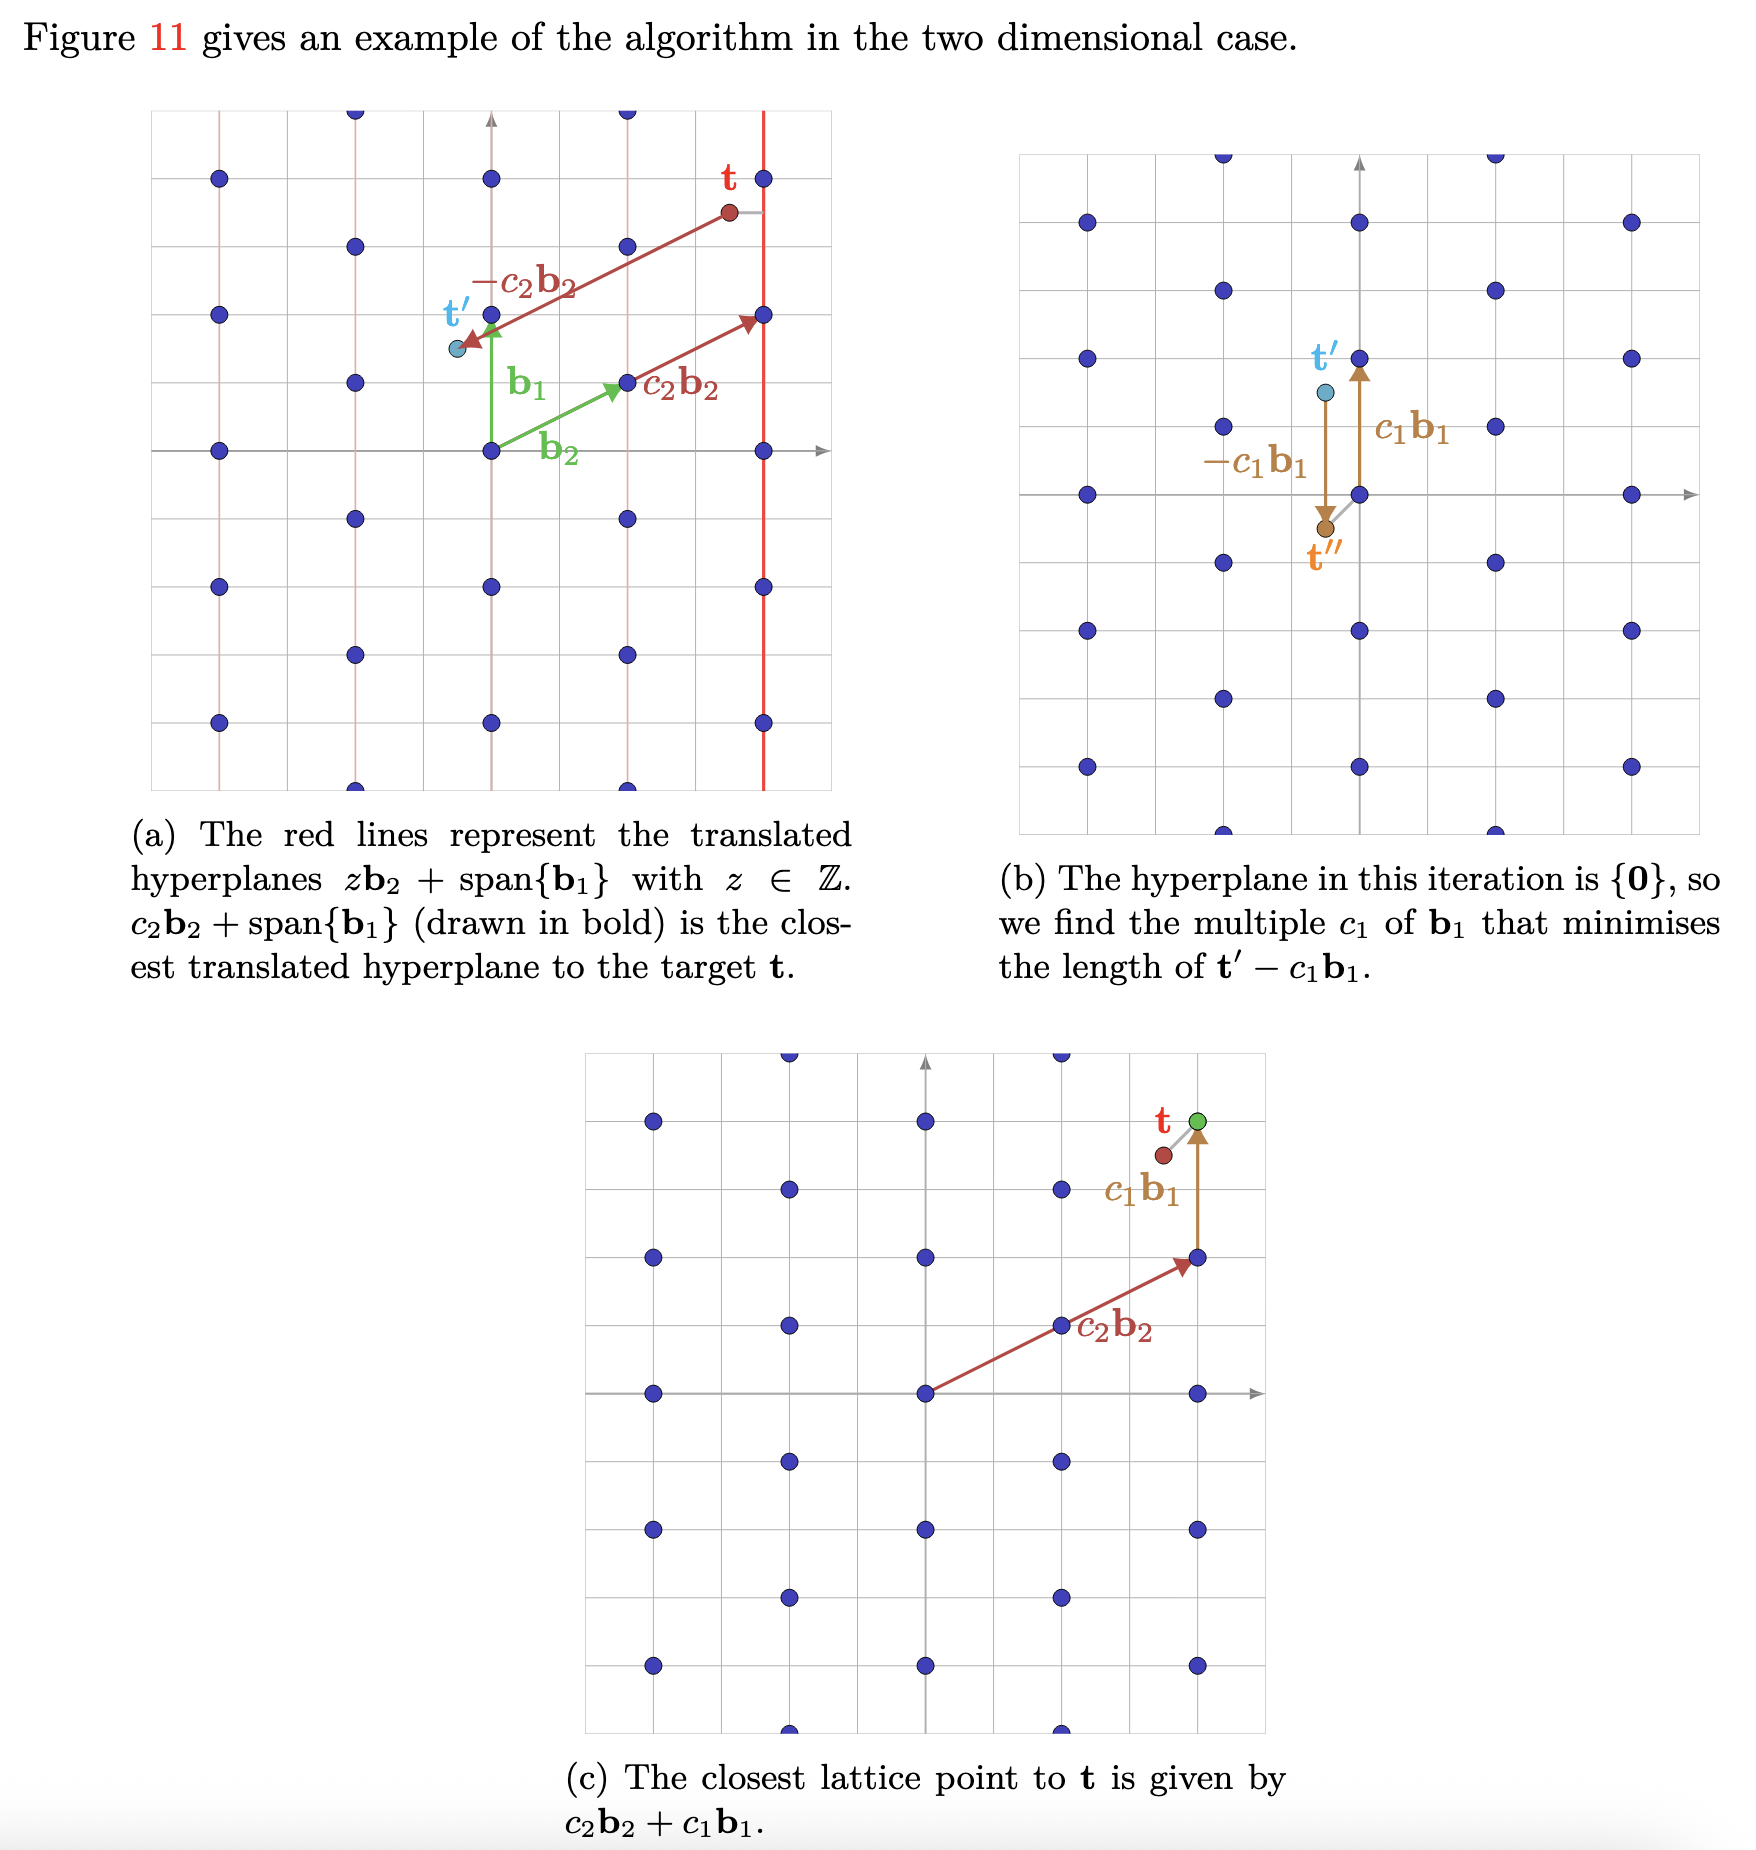

In [21]:
from sage.modules.free_module_integer import IntegerLattice
B = Matrix(ZZ, [[0, 2], [2, 1]])
L = IntegerLattice(B)
target = vector(QQ, [3.5, 3.5])
closest = L.closest_vector(target)
closest

(4, 4)